## Import libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
%matplotlib inline

## Data visualization on a few samples

Let's look at 5 random controls and 5 random PanIN samples. This is only to start to get an idea of what the spectrometry data looks like. 

First things first. The data files have very long names. I couldn't find out if thesse names were associated with some kind of information. I will start off by renaming all files in each folder to something more digestible. I may have to revisit this step if the file name do in fact, turn out to be important. Only one way to find out. 

In [70]:
import os

# Switch to folder with 'control' files
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control')

# Check if I'm in the right directory
#print(os.getcwd())

# Create arrays to store new file names
control_samples = []
panIN_samples = []

# Rename files in the Control folder
for file in os.listdir():
    #print(file)     # Get file names
    #print(os.path.splitext(file))     # Separate file name from extension
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files
    control_samples.append(file)     # Append new file names to array
    
# Rename files in the PanIN folder
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN')
for file in os.listdir():
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files
    panIN_samples.append(file)     # Append new file names to array

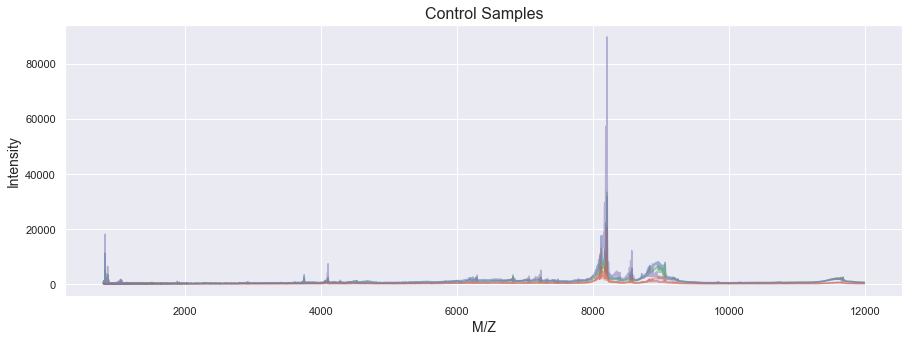

In [72]:
# Plot 5 random control samples
plt.figure(figsize=(15,5))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Control Samples', fontsize=16)

# Read in 5 random Control samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(control_samples))
    cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
    plt.plot(cs['M/Z'], cs['Intensity'], alpha=0.5)

On a quick (and crude) visual inspection, the spectrometry files seem to show consistent peaks for the 5 random control samples. Let's try the same for the PanIN samples.

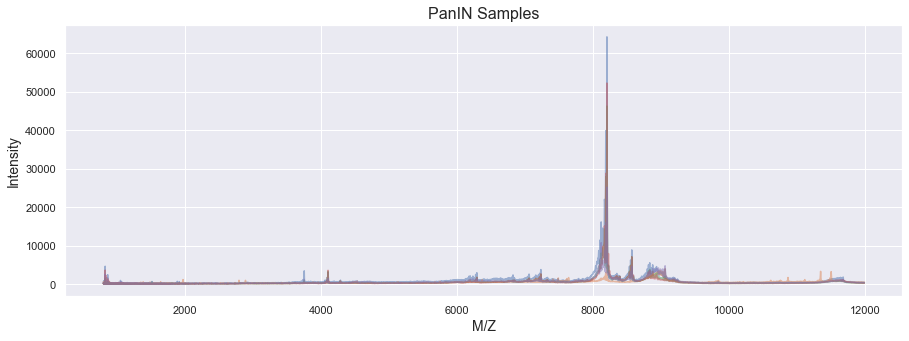

In [75]:
# Plot 5 random PanIN samples
plt.figure(figsize=(15,5))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('PanIN Samples', fontsize=16)

# Read in 5 random PanIN samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(panIN_samples))
    ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[n]))
    plt.plot(ps['M/Z'], ps['Intensity'], alpha=0.5)

Some PanIN samples show random peaks, but overall the peaks still seem fairly consistent. Now let's compare the controls and PanIN samples.

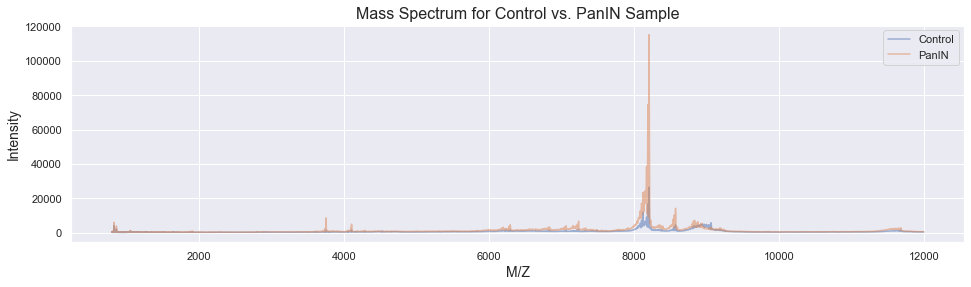

In [81]:
n = np.random.randint(low=0, high=len(control_samples))
cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
m = np.random.randint(low=0, high=len(panIN_samples))
ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[m]))
                                                                                                                      
plt.figure(figsize=[16,4])
plt.plot(cs['M/Z'], cs['Intensity'], alpha=0.5, label='Control')
plt.plot(ps['M/Z'], ps['Intensity'], alpha=0.5, label='PanIN')
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Mass Spectrum for Control vs. PanIN Sample', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Mass Spectrum.png')

If we were to just try to visually compare the spectra for a control and a PanIN sample, we could identify some peaks fairly well. But it would be quite difficult to identify all the key biomarkers. This is why we are trying to train a model to do this for us! 